# Определение "типичного клиента", поиск сезонности

## Импортирование библиотек, загрузка данных

In [62]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle


from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

In [63]:
data_1 = pd.read_csv('clients.csv')
data_2 = pd.read_csv('purchases.csv')

## Обработка таблицы clients

In [64]:
data_1.head(3)

,Unnamed: 0,Дата добавления,Тип карты,Номер карты,Моб.телефон,Фамилия,Имя,Отчество,Пол,Дата рождения,...,Инстаграм,ВКонтакте,Одноклассники,Адрес,Создан кассиром,Создан в магазине,Магазин,Адрес.1,Согласие на СМС,Согласие на рекламу
0,0,2022-10-22,Стандартная,3c69db03e1f1ea1996a5ebf241467308,5c13f30c21d9cef89ec9408c049497a7,d4feeb50ad08ceae4cc7beec4c6c012f,edaf1cec71662fd6650a5b1f4b6760bb,8d7e55567659b7cf21801e0728821eb0,NaN,2022-04-18 00:00:00,...,NaN,NaN,NaN,NaN,Интернет,Интернет,Интернет,NaN,Да,Да
1,1,2022-10-22,Стандартная,21ab2f983ac7ef581f6c0cd4a9f058a7,babb008e0127d702f62789baf388dbd6,5d18b53491853def86933c7ae83ebf4f,c5a8a46a9f8e0c638ca2d4768ba89931,83dd9ffa0ef298a5cb4089b5e98941b7,М,1986-09-16 00:00:00,...,NaN,NaN,NaN,NaN,Касса1,1,1,1.0,Да,Да
2,2,2022-10-22,Стандартная,7f768393a171d695439368439a812234,f8b8aec2bee7469bbc46943fb484c303,6fc32bd5fd3c102ccbdc03050c19c35b,3fb505ad1f928db15ce48d79d4e60c93,60b7f57fd0bac18fe028812e25b86893,М,1995-03-01 00:00:00,...,NaN,NaN,NaN,NaN,Касса1,1,1,1.0,Да,Да


In [65]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21004 entries, 0 to 21003
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              21004 non-null  int64  
 1   Дата добавления         21004 non-null  object 
 2   Тип карты               21004 non-null  object 
 3   Номер карты             21004 non-null  object 
 4   Моб.телефон             21004 non-null  object 
 5   Фамилия                 21004 non-null  object 
 6   Имя                     21004 non-null  object 
 7   Отчество                21004 non-null  object 
 8   Пол                     20039 non-null  object 
 9   Дата рождения           20836 non-null  object 
 10  По рекомендации         0 non-null      float64
 11  Всего бонусов           21004 non-null  float64
 12  Активные бонусы         21004 non-null  float64
 13  Неактивные бонусы       21004 non-null  int64  
 14  Получено бонусов        21004 non-null

In [66]:
sum(data_1.duplicated())

0

In [67]:
data_1['Номер карты'].unique().size, data_1['Моб.телефон'].unique().size

(21004, 21004)

In [68]:
data_1['Дата рождения'] = data_1['Дата рождения'].astype('str')

In [69]:
not_corr_b = sorted(data_1['Дата рождения'].unique(), reverse=True)[0:25]
not_corr_b

['nan',
 '7198-04-10 00:00:00',
 '4199-01-08 00:00:00',
 '2989-11-08 00:00:00',
 '2046-11-05 00:00:00',
 '2046-03-19 00:00:00',
 '2040-11-23 00:00:00',
 '2022-08-27 00:00:00',
 '2022-08-25 00:00:00',
 '2022-08-04 00:00:00',
 '2022-07-24 00:00:00',
 '2022-04-18 00:00:00',
 '2019-03-01 00:00:00',
 '2014-09-05 00:00:00',
 '2014-02-09 00:00:00',
 '2011-07-04 00:00:00',
 '2011-06-30 00:00:00',
 '2011-05-06 00:00:00',
 '2010-07-25 00:00:00',
 '2010-07-20 00:00:00',
 '2010-07-02 00:00:00',
 '2010-04-13 00:00:00',
 '2010-03-12 00:00:00',
 '2010-02-15 00:00:00',
 '2009-10-10 00:00:00']

In [70]:
data_1.loc[data_1['Дата рождения'].isin(not_corr_b), 'Дата рождения'] = np.nan

In [71]:
data_1['Тип карты'].unique()

array(['Стандартная'], dtype=object)

In [72]:
data_1['Адрес.1'].unique()

array([nan,  1.,  2.])

In [73]:
data_1['Магазин'].unique()

array(['Интернет', '1', '2', nan], dtype=object)

In [74]:
data_1['Дата добавления'] = pd.to_datetime(data_1['Дата добавления'], format='%Y-%m-%d')
data_1['Дата рождения'] = pd.to_datetime(data_1['Дата рождения'], format='%Y-%m-%d %H:%M:%S')
data_1['Дата последней покупки'] = pd.to_datetime(data_1['Дата последней покупки'], format='%Y-%m-%d')

In [75]:
oneyear = pd.Timedelta(days=365)
#df_ct_t = df_ct_t / oneday
data_1['Возраст'] = (pd.to_datetime('2022-10-28', format='%Y-%m-%d') - data_1['Дата рождения']) / oneyear

In [76]:
data_1['Время с добавления'] = (pd.to_datetime('2022-10-28', format='%Y-%m-%d') - data_1['Дата добавления']) / oneyear

In [77]:
data_1['Время с последней покупки'] = (pd.to_datetime('2022-10-28', format='%Y-%m-%d') - data_1['Дата последней покупки']) / oneyear

In [125]:
data_1.loc[16,:]

Unnamed: 0                                                 16
Дата добавления                           2022-10-21 00:00:00
Тип карты                                         Стандартная
Номер карты                  5749d8d16be676103bae74ebffc18799
Моб.телефон                  bd675647c430ee3292043e34e631a5cd
Фамилия                      e4ea2ee9ef2d3a4c0146d2de01b39c3e
Имя                          27c99be68ce241df9bd81ff490e79a9a
Отчество                     a24ac927b4b16b06840eb63bdb89064e
Пол                                                         Ж
Дата рождения                             1983-06-08 00:00:00
По рекомендации                                           NaN
Всего бонусов                                            27.0
Активные бонусы                                           0.0
Неактивные бонусы                                          27
Получено бонусов                                           38
Использовано бонусов                                      0.0
Дата пос

(0.0, 40000.0)

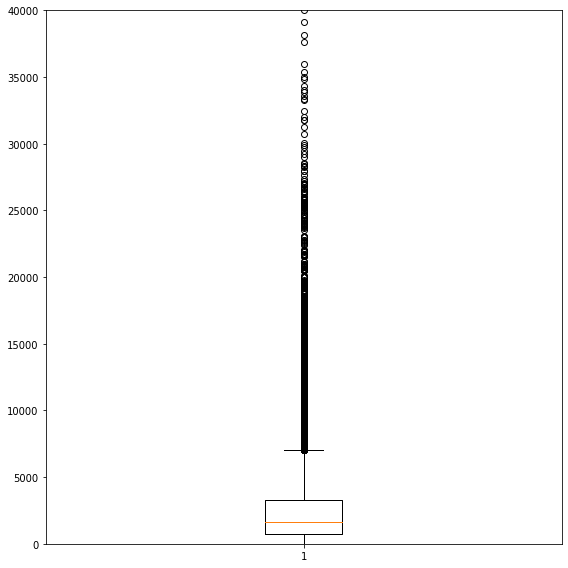

In [131]:
fig, axs = plt.pyplot.subplots(figsize=(8, 8), tight_layout=True)
plt.pyplot.boxplot(data_1['Средний чек (руб)'])
plt.pyplot.ylim([0, 40000])

Text(0.5, 1.0, 'Зависимость среднего чека от возраста')

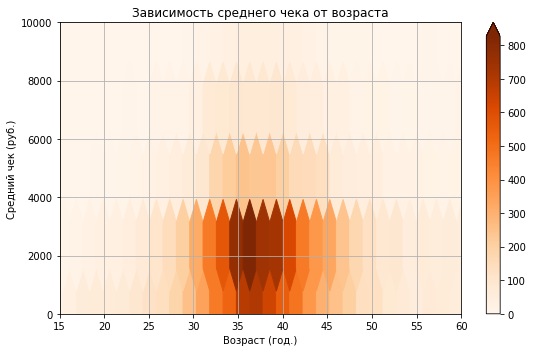

In [80]:
fig, axs = plt.pyplot.subplots(figsize=(8, 5), tight_layout=True)
color_map = plt.pyplot.cm.Spectral_r
image = plt.pyplot.hexbin(data_1['Возраст'], data_1['Средний чек (руб)'], gridsize=50, cmap = 'Oranges')
plt.pyplot.ylim([0, 10000])
plt.pyplot.xlim([15, 60])
plt.pyplot.grid(True)
cb = plt.pyplot.colorbar(image,spacing='uniform',extend='max')

axs.set_xlabel('Возраст (год.)')
axs.set_ylabel('Средний чек (руб.)')
plt.pyplot.title('Зависимость среднего чека от возраста')
#plt.pyplot.show()

Text(0.5, 1.0, 'Зависимость суммы покупок от возраста')

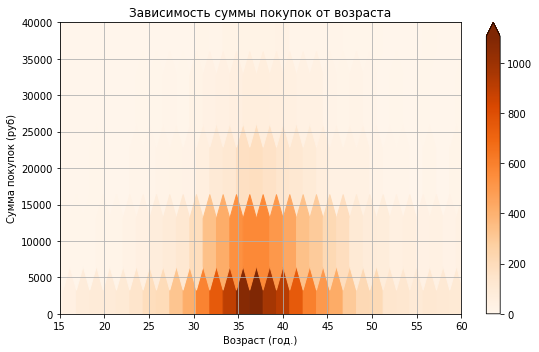

In [81]:
fig, axs = plt.pyplot.subplots(figsize=(8, 5), tight_layout=True)
color_map = plt.pyplot.cm.Spectral_r
image = plt.pyplot.hexbin(data_1['Возраст'], data_1['Сумма покупок (руб)'], gridsize=50, cmap = 'Oranges')
plt.pyplot.ylim([0, 40000])
plt.pyplot.xlim([15, 60])
plt.pyplot.grid(True)
cb = plt.pyplot.colorbar(image,spacing='uniform',extend='max')

axs.set_xlabel('Возраст (год.)')
axs.set_ylabel('Сумма покупок (руб)')
plt.pyplot.title('Зависимость суммы покупок от возраста')
#plt.pyplot.show()

In [134]:
rez = pd.concat([data_1.groupby('Пол')['Моб.телефон'].count(),
           data_1.groupby('Пол')['Средний чек (руб)'].mean(), 
           data_1.groupby('Пол')['Средний чек (руб)'].median(),
            data_1.groupby('Пол')['Покупок'].mean()], 
           axis = 1).set_axis(['Количество', 'Средний чек', 'Медиана среднего чека', 'Среднее число покупок'], axis=1).astype(int)
rez

,Количество,Средний чек,Медиана среднего чека,Среднее число покупок
Пол,,,,
Ж,11189,2780,1735,2
М,8850,2703,1539,2


In [128]:
data_1.loc[data_1['Покупок'] == 0, 'Номер карты'].count()

349

In [82]:
data_1.columns

Index(['Unnamed: 0', 'Дата добавления', 'Тип карты', 'Номер карты',
       'Моб.телефон', 'Фамилия', 'Имя', 'Отчество', 'Пол', 'Дата рождения',
       'По рекомендации', 'Всего бонусов', 'Активные бонусы',
       'Неактивные бонусы', 'Получено бонусов', 'Использовано бонусов',
       'Дата последней покупки', 'Покупок', 'Средний чек (руб)',
       'Сумма покупок (руб)', 'Инстаграм', 'ВКонтакте', 'Одноклассники',
       'Адрес', 'Создан кассиром', 'Создан в магазине', 'Магазин', 'Адрес.1',
       'Согласие на СМС', 'Согласие на рекламу', 'Возраст',
       'Время с добавления', 'Время с последней покупки'],
      dtype='object')

In [83]:
data_1_inf = data_1[['Время с последней покупки', 'Покупок', 'Средний чек (руб)', 'Сумма покупок (руб)', 'Время с добавления']]

In [84]:
data_1_inf = data_1_inf.dropna()

In [85]:
data_1_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20716 entries, 1 to 21003
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Время с последней покупки  20716 non-null  float64
 1   Покупок                    20716 non-null  int64  
 2   Средний чек (руб)          20716 non-null  float64
 3   Сумма покупок (руб)        20716 non-null  float64
 4   Время с добавления         20716 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 971.1 KB


In [86]:
ss = StandardScaler()
k_mean_scaled = ss.fit_transform(data_1_inf)

In [88]:
k_mean_scaled_data = pd.DataFrame(k_mean_scaled, columns=data_1_inf.columns)

In [90]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(k_mean_scaled_data)
    distortion.append(model.inertia_)

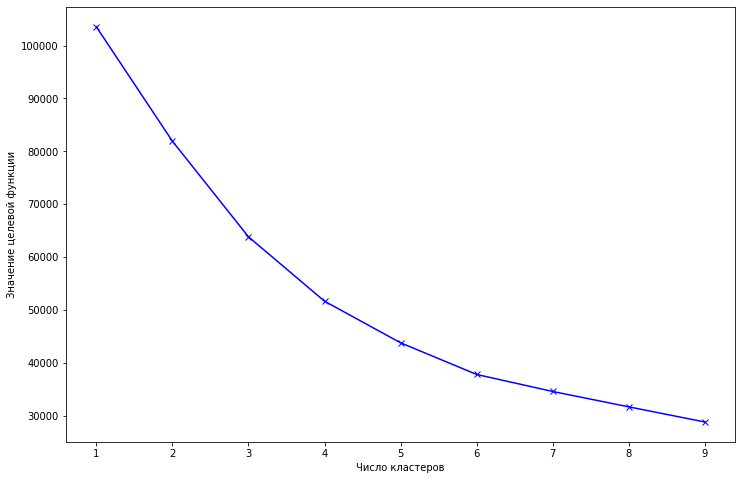

In [91]:
plt.pyplot.figure(figsize=(12, 8))
plt.pyplot.plot(K, distortion, 'bx-')
plt.pyplot.xlabel('Число кластеров')
plt.pyplot.ylabel('Значение целевой функции')
plt.pyplot.show() 

По методу клюшки можно определить что оптимальное количество кластеров 3 - 4.

In [92]:
model = KMeans(n_clusters=3, random_state=12345)
model.fit(k_mean_scaled_data)

KMeans(n_clusters=3, random_state=12345)

In [99]:
pd.DataFrame(ss.inverse_transform(model.cluster_centers_), columns=k_mean_scaled_data.columns)

,Время с последней покупки,Покупок,Средний чек (руб),Сумма покупок (руб),Время с добавления
0,0.545328,1.849336,2382.544640,3898.897182,0.813400
1,1.483652,1.818119,2139.024412,3458.245414,1.765543
2,0.474117,6.799368,4973.428516,20206.817367,1.763225


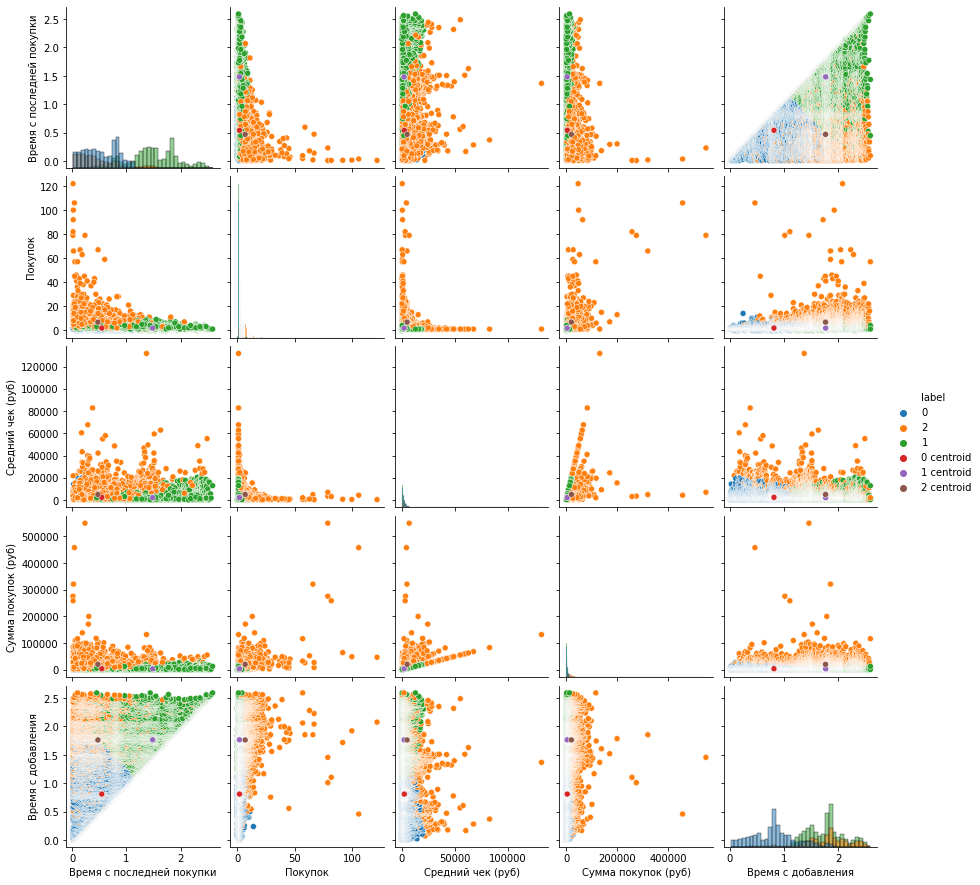

In [98]:
centroids = pd.DataFrame(ss.inverse_transform(model.cluster_centers_), columns=data_1_inf.columns[:-1])
data_1_inf['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
data_all = pd.concat([data_1_inf, centroids], ignore_index=True)

pairgrid = sns.pairplot(data_all, hue='label', diag_kind='hist')

## Выводы:
Данные выгружены корректно. Дубликаты отсутствуют.
строки "По рекомендации" и соц сети не активны. В графе возраст есть ряд очевидно ложных значений.  Так же есть 349 (чуть больше процента от общего числа) пользователей которые оформили карту но не совершили ни одной покупки.

При составлении обобщённого портрета покупателя можно сделать вывод что покупают чаще всего люди возрастом 35-45 лет (наиболее активны от 30 до 40).
Средняя покупка в районе 1-2 тысяч, при этом покупки дороже 8 тысяч являются сравнительно редкими (выбросы на диаграмме ящика с усами).
Клиентов-женщин больше чем мужчин, так же у женщин немного выше средний чек. При этом среднее и медиана различны и у мужчин разница больше, это значит что мужчины обычно покупают на меньшую сумму но порой совершают крупные покупки. Среднее количество покупок одинаковое у мужчин и у женщин. 



С помощью метода клюшки и кластеризации методом KMeans можно выделить три группы посетителей. 
Первая группа - недавно зарегистрированные клиенты у которых мало покупок и небольшие траты.
Вторая группа - давно зарегистрированные клиенты у которых много покупок и большие траты. Третья группа - давно зарегистрированные клиенты с малым числом покупок и малыми тратами.

Проще говоря у нас будут "активные клиенты", "неактивные клиенты" и "недавно пришедшие клиенты" про которых пока невозможно сказать ничего определённого.

## Обработка таблицы purchases

In [136]:
data_2.head(3)

,Unnamed: 0,Дата операции,Тип операции,Моб.телефон,Списано бонусов,Начислено бонусов,№ чека,Сумма покупки,Сумма скидки,Оплата в рублях,Оплата бонусами,Тип карты,Номер карты,Кассир,Магазин,Комментарий,Товар,Количество,Категория товара,Дополнительная информация
0,0,2022-10-23,Покупка,e41ae15e64ed6f2d2b37caf2023903b0,0.0,0.0,60560.0,6.0,0.0,6.0,0.0,Стандартная,c1a0b6a21175d40691f046a448ed33a7,Касса1,1.0,NaN,NaN,1.0,NaN,NaN
1,1,2022-10-23,Покупка,e41ae15e64ed6f2d2b37caf2023903b0,499.0,45.0,60560.0,4999.0,0.0,4500.0,499.0,Стандартная,c1a0b6a21175d40691f046a448ed33a7,Касса1,1.0,NaN,NaN,1.0,Начисление 1 списание 10,"Начисление бонусов: 45 (Основные настройки, ка..."
2,2,2022-10-23,Покупка,3281acace8e8d42572c5a0e3ab67a938,406.1,108.0,60559.0,3999.0,0.0,3592.9,406.1,Стандартная,f2f76029fc6490531b997348bce55922,Касса3,2.0,NaN,NaN,1.0,Начисление 3 списание 20,"Начисление бонусов: 108 (Основные настройки, к..."


In [137]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260922 entries, 0 to 260921
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 260922 non-null  int64  
 1   Дата операции              260922 non-null  object 
 2   Тип операции               260922 non-null  object 
 3   Моб.телефон                260922 non-null  object 
 4   Списано бонусов            260205 non-null  float64
 5   Начислено бонусов          259639 non-null  float64
 6   № чека                     111247 non-null  float64
 7   Сумма покупки              111247 non-null  float64
 8   Сумма скидки               111247 non-null  float64
 9   Оплата в рублях            111247 non-null  float64
 10  Оплата бонусами            260922 non-null  float64
 11  Тип карты                  109827 non-null  object 
 12  Номер карты                260922 non-null  object 
 13  Кассир                     11

In [138]:
data_2['Дата операции'] = pd.to_datetime(data_2['Дата операции'], format='%Y-%m-%d')
data_2['Дата операции'].max(),  data_2['Дата операции'].min()


(Timestamp('2022-10-23 00:00:00'), Timestamp('2020-03-27 00:00:00'))

In [139]:
data_2['Тип операции'].unique()

array(['Покупка', 'Подарок на день рождения близких',
       'Подарок на день рождения', 'Автоматическое сгорание',
       'Корректировка', 'Возврат', 'Подарок'], dtype=object)

In [140]:
data_2['Комментарий'].unique()

array([nan, 'Возврат'], dtype=object)

In [142]:
data_2['Категория товара'].unique()

array([nan, 'Начисление 1 списание 10', 'Начисление 3 списание 20',
       'Начисление 5 списание 20', 'Начисление 0 списание 0'],
      dtype=object)

In [141]:
data_2['Магазин'].unique()

array([ 1.,  2., nan])

In [ ]:
data_2_filtr_1 = data_2[data_2['Тип операции'] == 'Покупка']

In [147]:
tim_ser_sum_all = data_2[data_2['Тип операции'] == 'Покупка'].groupby('Дата операции')['Сумма покупки'].sum()
tim_ser_count_all = data_2[data_2['Тип операции'] == 'Покупка'].groupby('Дата операции')['Сумма покупки'].count()

tim_ser_sum_m1 = data_2[(data_2['Тип операции'] == 'Покупка')&(data_2['Магазин'] == 1)].groupby('Дата операции')['Сумма покупки'].sum()
tim_ser_count_m1 = data_2[(data_2['Тип операции'] == 'Покупка')&(data_2['Магазин'] == 1)].groupby('Дата операции')['Сумма покупки'].count()

tim_ser_sum_m2 = data_2[(data_2['Тип операции'] == 'Покупка')&(data_2['Магазин'] == 2)].groupby('Дата операции')['Сумма покупки'].sum()
tim_ser_count_m2 = data_2[(data_2['Тип операции'] == 'Покупка')&(data_2['Магазин'] == 2)].groupby('Дата операции')['Сумма покупки'].count()

In [149]:
tim_ser_sum_all.index.is_monotonic

True

Text(0, 0.5, 'Выручка млн')

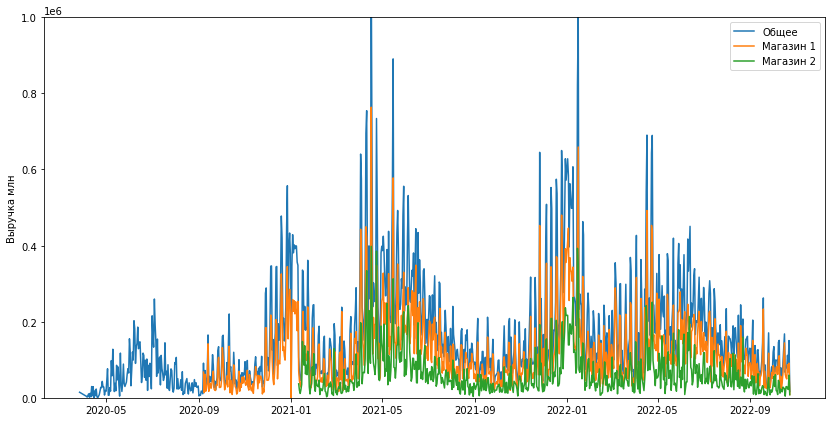

In [164]:
plt.pyplot.figure(figsize=(14, 7))
plt.pyplot.plot(tim_ser_sum_all, label = 'Общее')
plt.pyplot.plot(tim_ser_sum_m1, label = 'Магазин 1')
plt.pyplot.plot(tim_ser_sum_m2, label = 'Магазин 2')

plt.pyplot.legend()
plt.pyplot.ylim([0, 1000000])
plt.pyplot.ylabel('Выручка млн')

In [166]:
data_all = tim_ser_sum_all.resample('1W').sum() 

In [187]:
data_all = tim_ser_sum_all.resample('5D').sum() 
decomposed_all = seasonal_decompose(data_all)

data_m1 = tim_ser_sum_m1.resample('5D').sum() 
decomposed_m1 = seasonal_decompose(data_m1)

data_m2 = tim_ser_sum_m2.resample('5D').sum() 
decomposed_m2 = seasonal_decompose(data_m2)

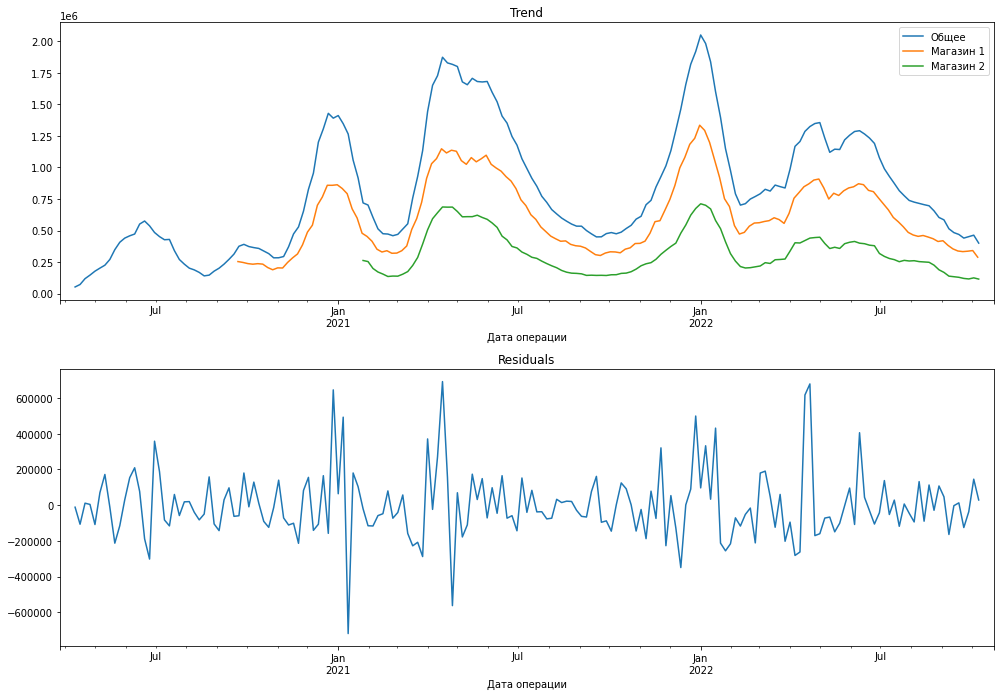

In [195]:
plt.pyplot.figure(figsize=(14, 14))
plt.pyplot.subplot(311)

decomposed_all.trend.plot(ax=plt.pyplot.gca(), label = 'Общее')
decomposed_m1.trend.plot(ax=plt.pyplot.gca(), label = 'Магазин 1')
decomposed_m2.trend.plot(ax=plt.pyplot.gca(), label = 'Магазин 2')
plt.pyplot.legend()
plt.pyplot.title('Trend')
plt.pyplot.subplot(312)
decomposed_all.resid.plot(ax=plt.pyplot.gca()) 
plt.pyplot.title('Residuals')
plt.pyplot.tight_layout()

## Выводы:

Анализ временных рядов позволяет сделать вывод что за год выделяются два пика выручки "околоновогодний" - за месяц перед новым годом и две недели после него и "летний" - с апреля по июль. В свою очередь летний делится на пик в апреле (можно предположить что люди закупаются к лету) и в июне (отпуска?).


Если судить по 2021 году, летние максимумы приносят немного больше выручки чем новогодний пик. Исходя из ослабления экономики в связи с международной обстановкой можно сделать вывод что наступающий новогодний пик выручки будет равен или немного меньше выручки за июнь.